In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.compose import ColumnTransformer
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, cross_validate,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler,Normalizer,MinMaxScaler,OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

# Loading Dataset

In [2]:
train=pd.read_excel('Datasets\\Flight Price\\train.xlsx')
test=pd.read_excel('Datasets\\Flight Price\\test.xlsx')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Null Value Identification and Imputation

In [3]:
# Checking null counts in train and test data

train_null_counts=pd.DataFrame(train.isnull().sum(),columns=['train_null_count'])
train_null_counts=train_null_counts.loc[train_null_counts.train_null_count>0]
test_null_counts=pd.DataFrame(test.isnull().sum(),columns=['test_null_count'])
test_null_counts=test_null_counts.loc[test_null_counts.test_null_count>0]
null_counts=train_null_counts.join(test_null_counts).fillna(0)
null_counts['train_null_%']=round((null_counts['train_null_count']/train.shape[0])*100,2)
null_counts['test_null_%']=round((null_counts['test_null_count']/test.shape[0])*100,2)
null_counts

,train_null_count,test_null_count,train_null_%,test_null_%
Route,1,0.0,0.01,0.0
Total_Stops,1,0.0,0.01,0.0


In [4]:
train.dropna(inplace=True)

# Exploratory Data Analysis

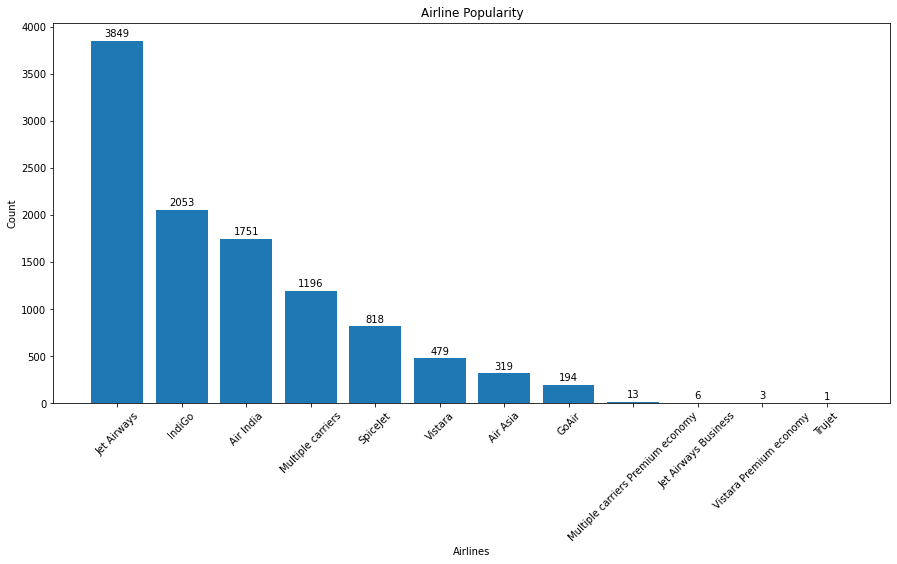

In [5]:
fig,ax=plt.subplots(figsize=(15,7))
ax.bar(x=train['Airline'].value_counts().index,height=train['Airline'].value_counts().values)
ax.set_xlabel('Airlines')
ax.set_ylabel('Count')
ax.set_title('Airline Popularity')
ax.set_xticklabels(train['Airline'].value_counts().index, rotation = 45)
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

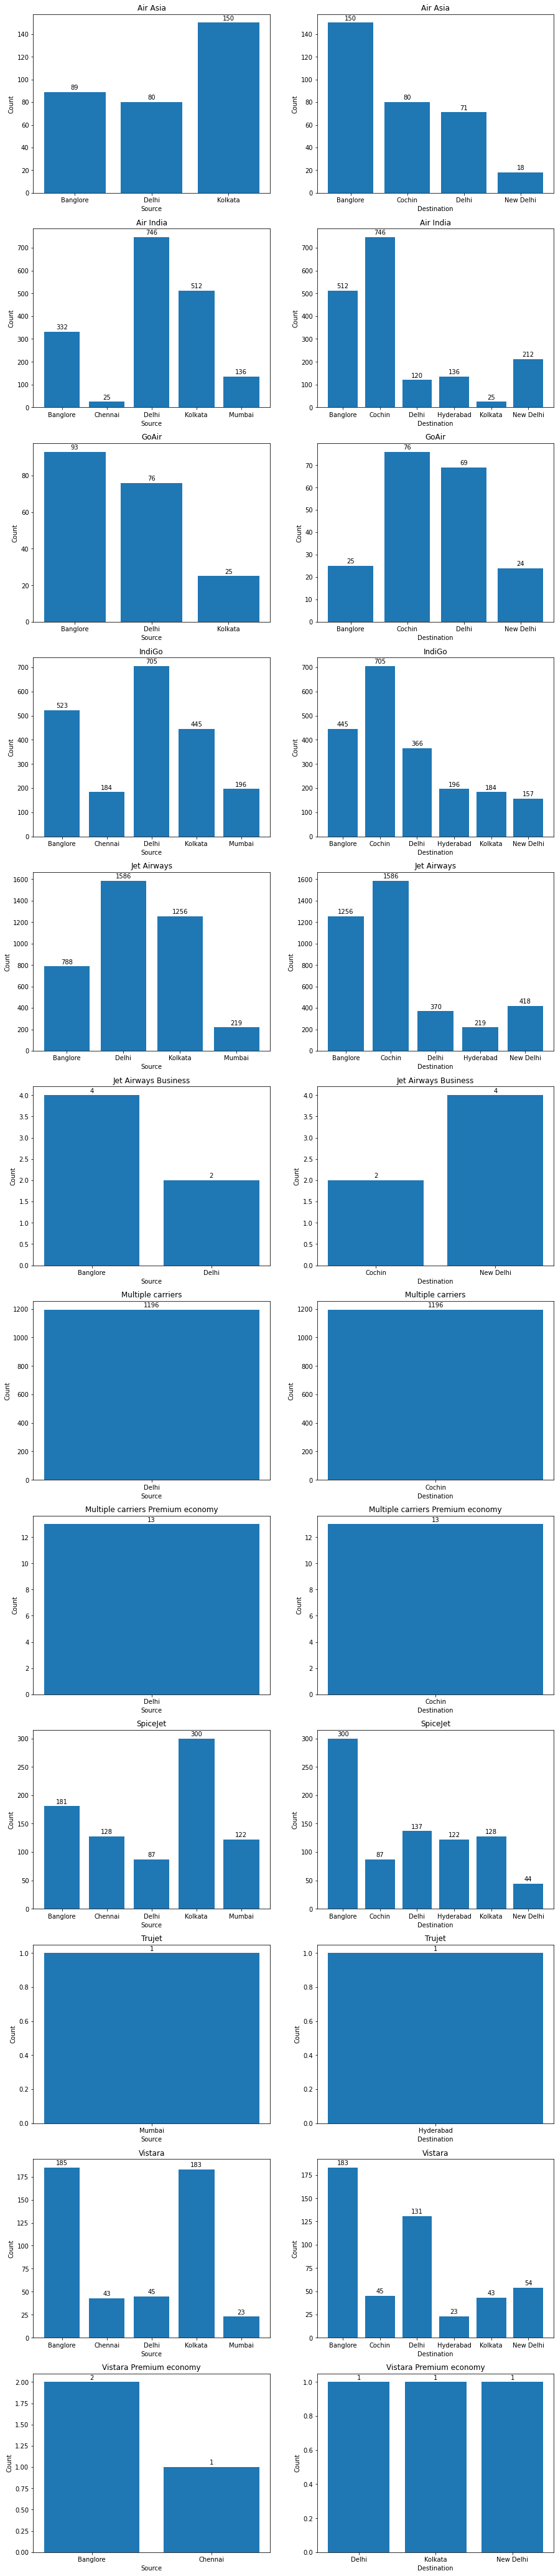

In [6]:
airline_list=train['Airline'].value_counts().index.to_list()*2
airline_list.sort()
group1=train.groupby(['Airline','Source']).count()['Route']
group2=train.groupby(['Airline','Destination']).count()['Route']
fig,ax=plt.subplots(figsize=(15,75),ncols=2,nrows=12)
for i,j,k in zip(ax.flat,airline_list,range(len(airline_list))):
    if np.mod(k,2)==0:
        i.bar(x=group1.loc[j].index,height=group1.loc[j].values)
        i.set_xlabel('Source')
    else:
        i.bar(x=group2.loc[j].index,height=group2.loc[j].values)
        i.set_xlabel('Destination')
    i.set_ylabel('Count')
    i.set_title(j)
    for p in i.patches:
        h = p.get_height()
        x = p.get_x()+p.get_width()/2
        i.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

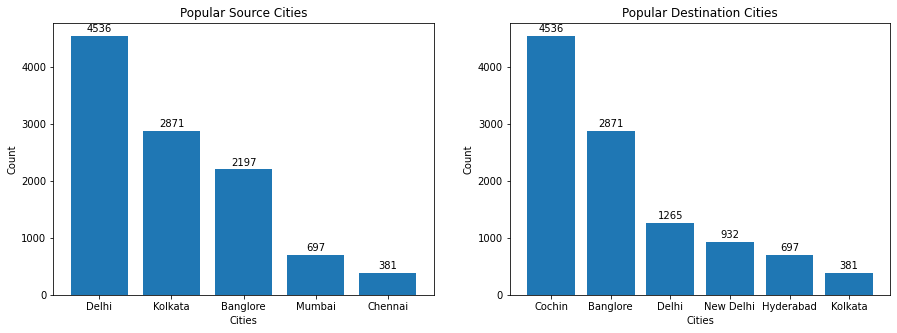

In [7]:
fig,ax=plt.subplots(figsize=(15,5),nrows=1,ncols=2)
for i,j in zip(ax.flat,['Source','Destination']):
    i.bar(x=train[j].value_counts().index,height=train[j].value_counts().values)
    i.set_xlabel('Cities')
    i.set_ylabel('Count')
    i.set_title('Popular '+j+' Cities')
    for p in i.patches:
        h = p.get_height()
        x = p.get_x()+p.get_width()/2
        i.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

In [8]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


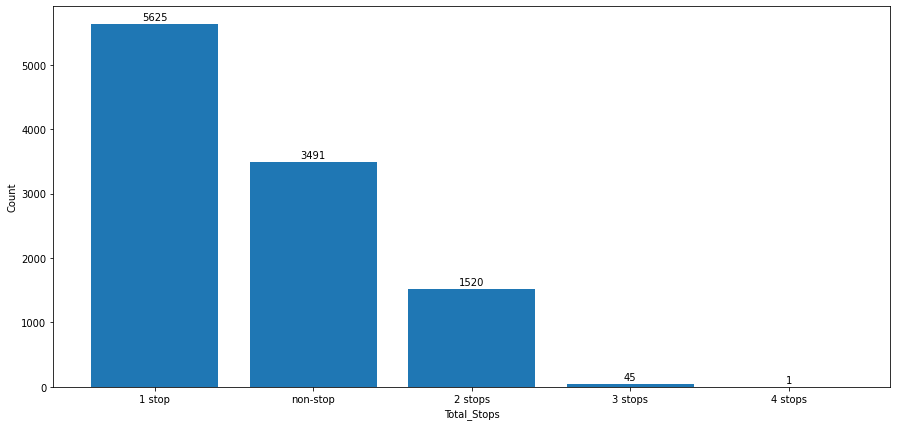

In [9]:
fig,ax=plt.subplots(figsize=(15,7))
ax.bar(x=train['Total_Stops'].value_counts().index,height=train['Total_Stops'].value_counts().values)
ax.set_xlabel('Total_Stops')
ax.set_ylabel('Count')
ax.set_xticks(train['Total_Stops'].value_counts().index)
ax.set_xticklabels(train['Total_Stops'].value_counts().index)
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

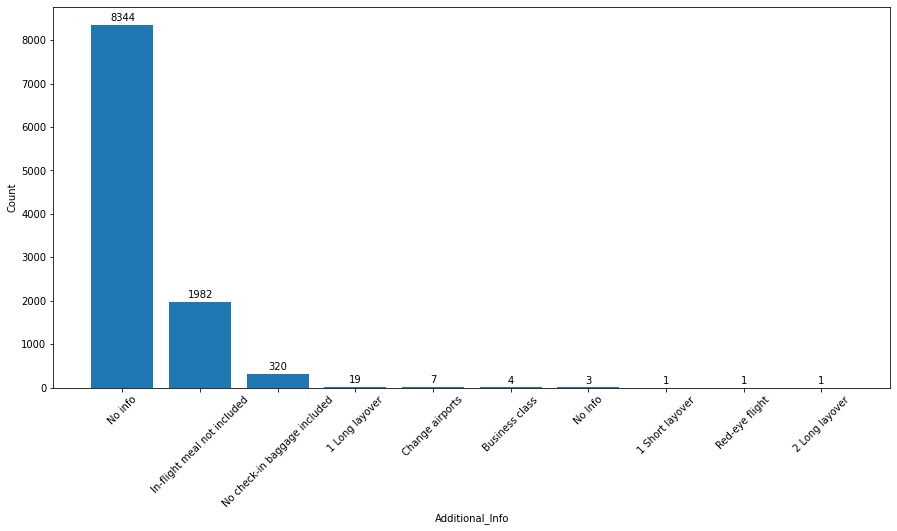

In [10]:
fig,ax=plt.subplots(figsize=(15,7))
ax.bar(x=train['Additional_Info'].value_counts().index,height=train['Additional_Info'].value_counts().values)
ax.set_xlabel('Additional_Info')
ax.set_ylabel('Count')
ax.set_xticklabels(train['Additional_Info'].value_counts().index,rotation=45)
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

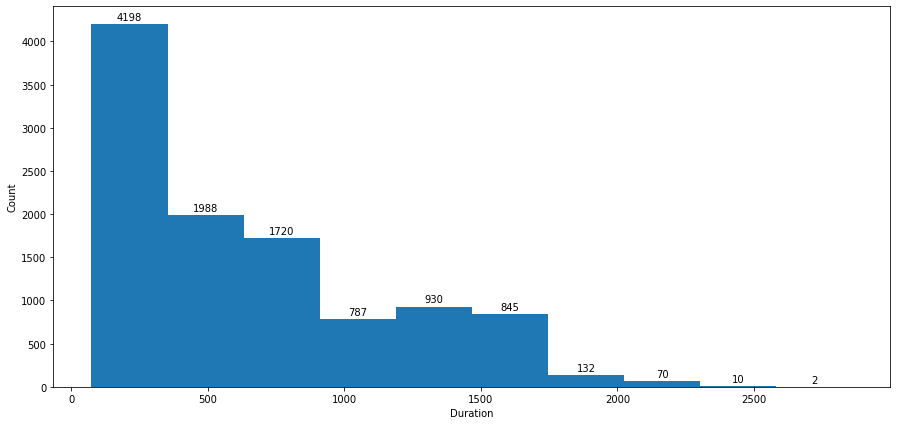

In [11]:
train['Duration']=train['Duration'].apply(lambda x: re.split('[/shm]',x))
train['Duration_Hour']=train['Duration'].apply(lambda x: int(x[0]))
train['Duration_Min']=train['Duration'].apply(lambda x: int(x[1]) if len(x)>2 else 0)

fig,ax=plt.subplots(figsize=(15,7))
ax.hist(x=train['Duration_Hour']*60+train['Duration_Min'])
ax.set_xlabel('Duration')
ax.set_ylabel('Count')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

<AxesSubplot:xlabel='Price', ylabel='Density'>

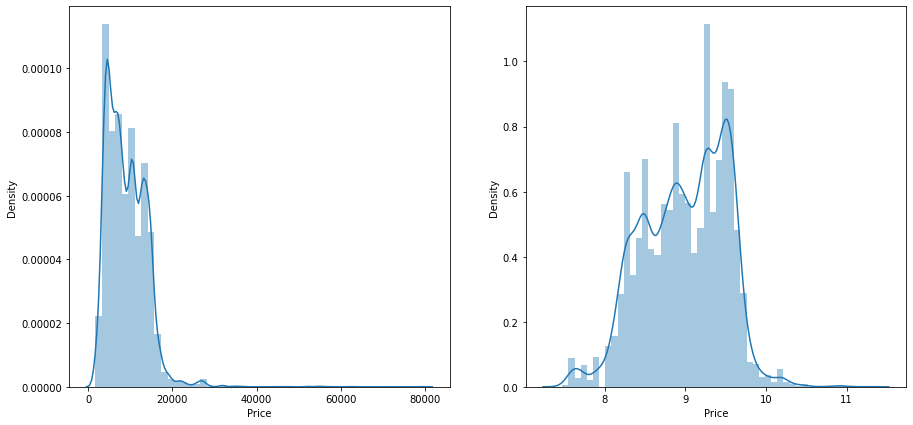

In [12]:
fig,ax=plt.subplots(figsize=(15,7),ncols=2,nrows=1)
sns.distplot(train['Price'],ax=ax[0])
sns.distplot(np.log(train['Price']),ax=ax[1])

Text(0.5, 1.0, 'Price vs Airline')

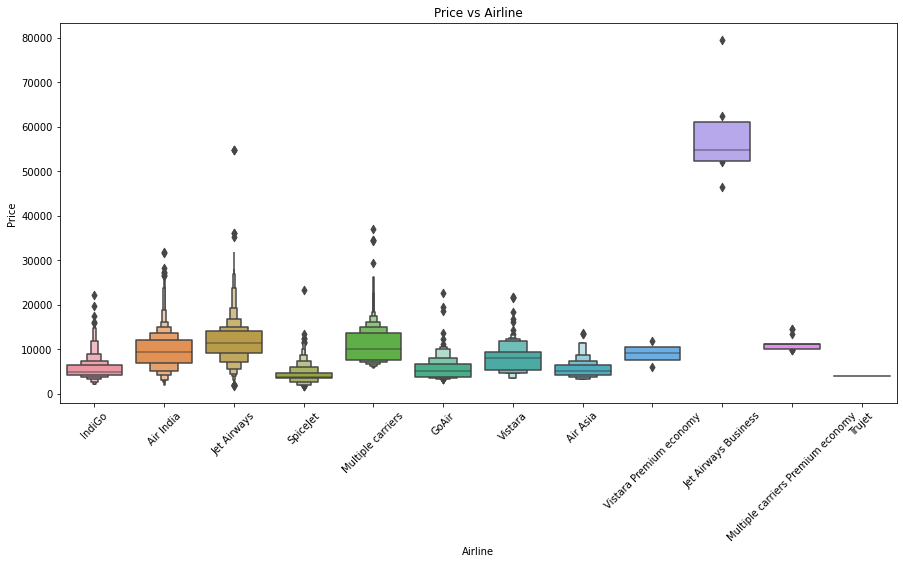

In [13]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Airline'],y=train['Price'])
ax.set_xticklabels(train['Airline'].unique(),rotation=45)
ax.set_title('Price vs Airline')

<AxesSubplot:xlabel='Source', ylabel='Price'>

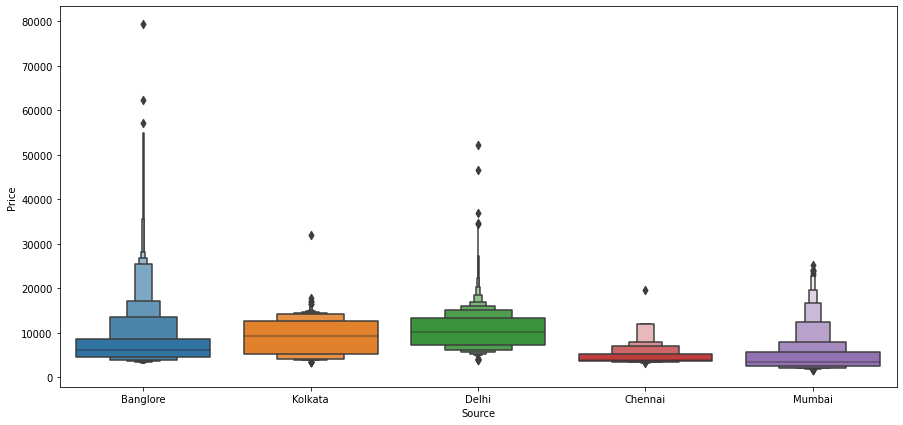

In [14]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Source'],y=train['Price'])

<AxesSubplot:xlabel='Destination', ylabel='Price'>

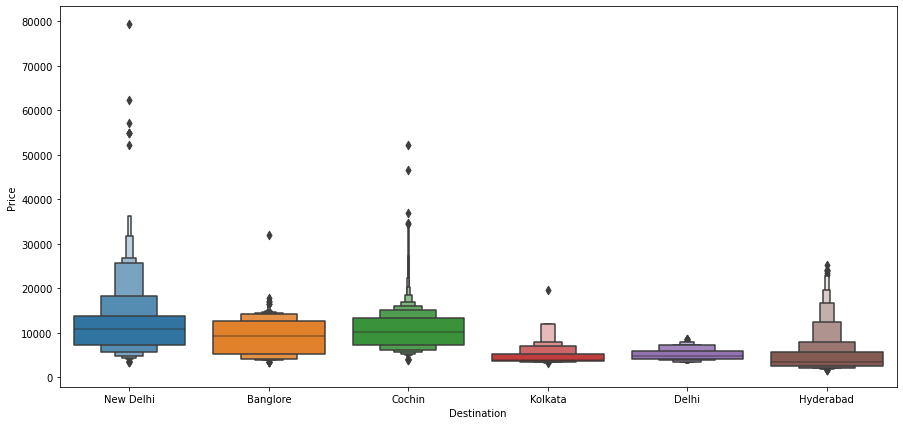

In [15]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Destination'],y=train['Price'])

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

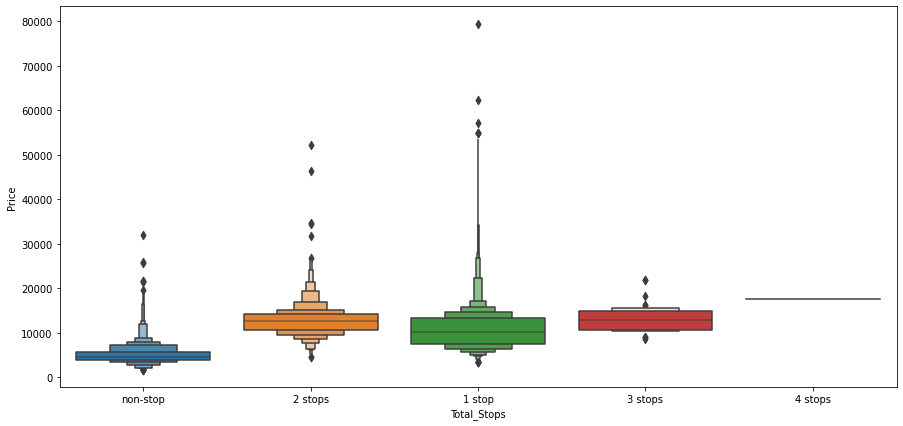

In [16]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Total_Stops'],y=train['Price'])

[Text(0, 0, 'No info'),
 Text(1, 0, 'In-flight meal not included'),
 Text(2, 0, 'No check-in baggage included'),
 Text(3, 0, '1 Short layover'),
 Text(4, 0, 'No Info'),
 Text(5, 0, '1 Long layover'),
 Text(6, 0, 'Change airports'),
 Text(7, 0, 'Business class'),
 Text(8, 0, 'Red-eye flight'),
 Text(9, 0, '2 Long layover')]

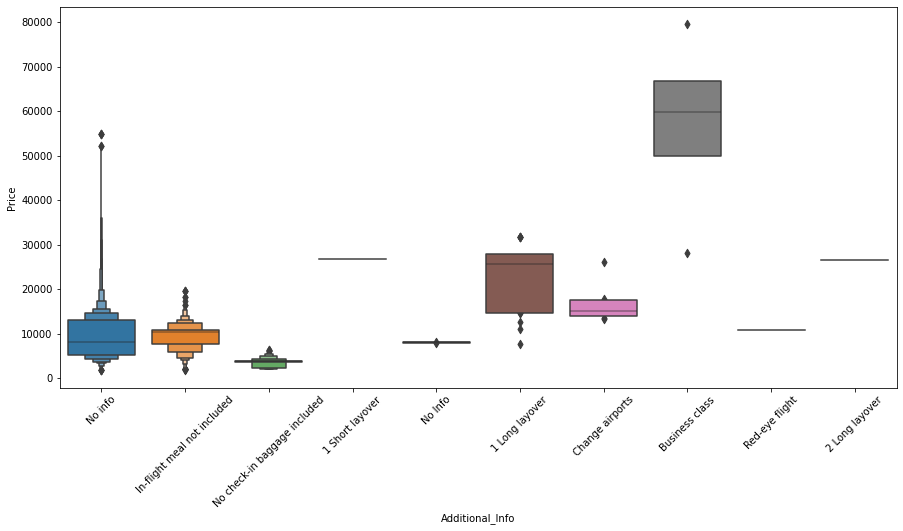

In [17]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Additional_Info'],y=train['Price'])
ax.set_xticklabels(train['Additional_Info'].unique(),rotation=45)

Text(0, 0.5, 'Price')

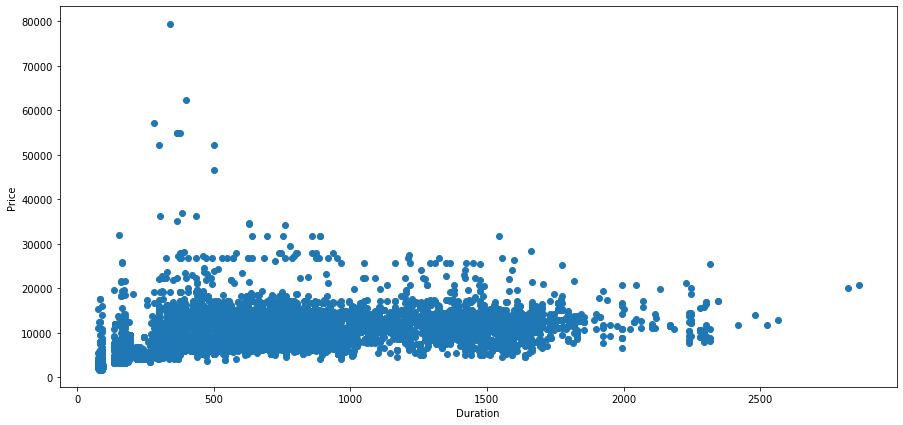

In [18]:
fig,ax=plt.subplots(figsize=(15,7))
ax.scatter(x=train['Duration_Hour']*60+train['Duration_Min'],y=train['Price'])
ax.set_xlabel('Duration')
ax.set_ylabel('Price')

Text(0, 0.5, 'Duration')

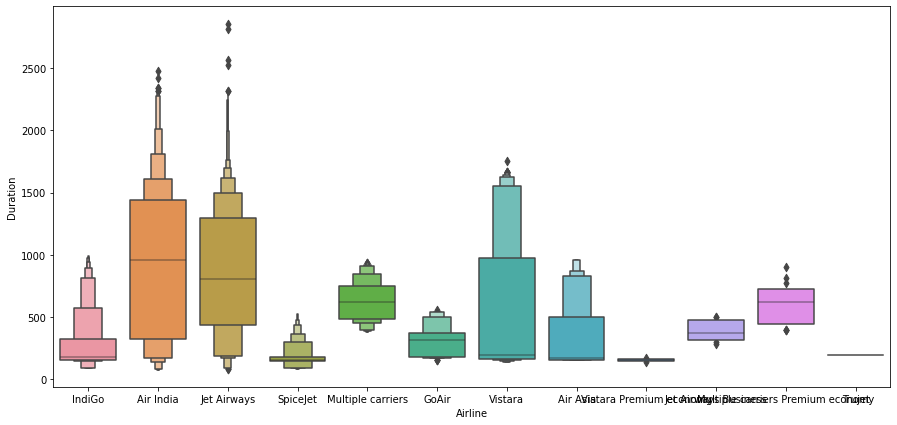

In [19]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Airline'],y=train['Duration_Hour']*60+train['Duration_Min'])
ax.set_ylabel('Duration')

Text(0, 0.5, 'Duration')

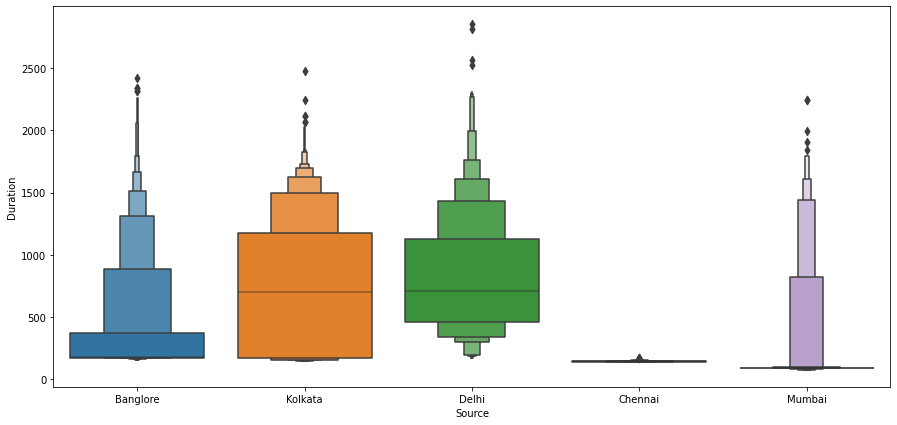

In [20]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Source'],y=train['Duration_Hour']*60+train['Duration_Min'])
ax.set_ylabel('Duration')

Text(0, 0.5, 'Duration')

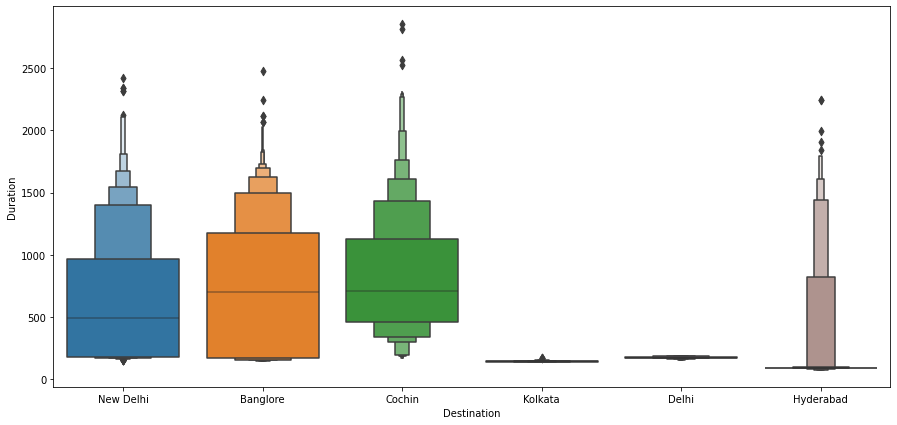

In [21]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Destination'],y=train['Duration_Hour']*60+train['Duration_Min'])
ax.set_ylabel('Duration')

Text(0, 0.5, 'Duration')

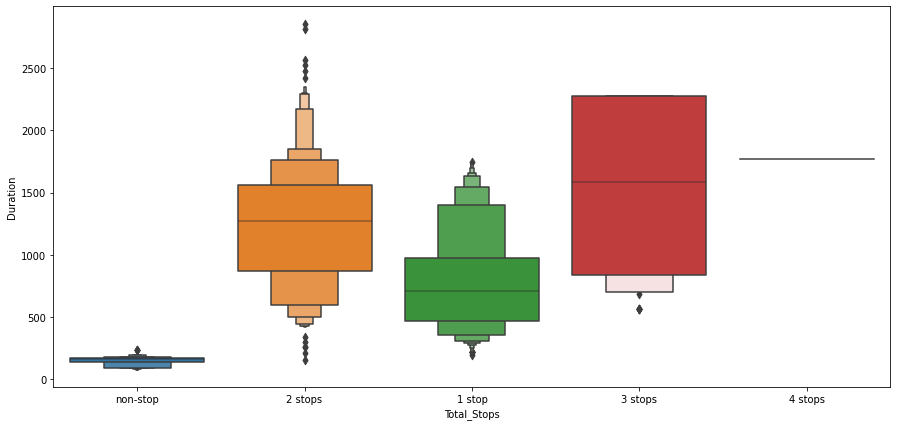

In [22]:
fig,ax=plt.subplots(figsize=(15,7))
sns.boxenplot(x=train['Total_Stops'],y=train['Duration_Hour']*60+train['Duration_Min'])
ax.set_ylabel('Duration')

# Feature Engineering

In [23]:
train['Year']=pd.to_datetime(train['Date_of_Journey']).dt.year
train['Month']=pd.to_datetime(train['Date_of_Journey']).dt.month
train['Day']=pd.to_datetime(train['Date_of_Journey']).dt.day

train['Total_Stops'].replace(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],[0,2,1,3,4],inplace=True)

train['Arrival_Time']=pd.to_datetime(train['Arrival_Time'])
train['Dep_Time']=pd.to_datetime(train['Dep_Time'])

train['Dep_Hour']=train['Dep_Time'].dt.hour
train['Dep_Min']=train['Dep_Time'].dt.minute
train['Arrival_Hour']=train['Arrival_Time'].dt.hour
train['Arrival_Min']=train['Arrival_Time'].dt.minute

In [24]:
test['Duration']=test['Duration'].apply(lambda x: re.split('[/shm]',x))
test['Duration_Hour']=test['Duration'].apply(lambda x: int(x[0]))
test['Duration_Min']=test['Duration'].apply(lambda x: int(x[1]) if len(x)>2 else 0)

test['Year']=pd.to_datetime(test['Date_of_Journey']).dt.year
test['Month']=pd.to_datetime(test['Date_of_Journey']).dt.month
test['Day']=pd.to_datetime(test['Date_of_Journey']).dt.day

test['Total_Stops'].replace(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],[0,2,1,3,4],inplace=True)

test['Arrival_Time']=pd.to_datetime(test['Arrival_Time'])
test['Dep_Time']=pd.to_datetime(test['Dep_Time'])

test['Dep_Hour']=test['Dep_Time'].dt.hour
test['Dep_Min']=test['Dep_Time'].dt.minute
test['Arrival_Hour']=test['Arrival_Time'].dt.hour
test['Arrival_Min']=test['Arrival_Time'].dt.minute

In [25]:
print(train['Additional_Info'].value_counts(),
      'No Info % = '+str(train['Additional_Info'].value_counts()['No info']/len(train)))

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64 No Info % = 0.781127129750983


In [26]:
# Arrival Time not required as we have Departure time and total duration
# More than 75% of the data does not contain additional info
# Date of journey not required as we have extacted month and day from it
# Year is not required as its the same year for all observations
# Arrival_Time and Dep_Time not required as we have extracted hours and mins into separate columns
# Additional Info not required as more the 75% data has no info

In [27]:
drop=['Price','Arrival_Time','Date_of_Journey','Arrival_Time','Dep_Time','Additional_Info','Duration','Year', 'Route']
x=train[[x for x in train.columns if x not in drop]]
y=train[['Price']]
# x=pd.get_dummies(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=1)

In [28]:
ct=ColumnTransformer([('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'),
                      ['Source','Destination','Airline'])],remainder='passthrough')

# Model Evaluation and Selection

In [29]:
models=[LinearRegression(), Lasso(random_state=1),Ridge(random_state=1),DecisionTreeRegressor(random_state=1),
       RandomForestRegressor(random_state=1,n_jobs=-1)]
result=[]
for model in models:
    pipe=Pipeline([('ct',ct),('model',model)])
    score=cross_val_score(estimator=pipe,X=x_train,y=np.array(y_train).ravel(),cv=10,n_jobs=-1,
                          scoring='r2').mean()
    result.append(score)
base_result=pd.DataFrame(result,index=['Linear Regression','Lasso','Ridge', 'Decision Tree Regression','Random Forest Regressor'],
             columns=['R^2 Score'])
base_result

,R^2 Score
Linear Regression,0.614561
Lasso,0.614877
Ridge,0.613056
Decision Tree Regression,0.700489
Random Forest Regressor,0.803864


In [30]:
pipe=Pipeline([('ct',ct),('model',RandomForestRegressor(random_state=1,n_jobs=-1))])
pipe.fit(x_train,np.array(y_train).ravel())
y_pred=pipe.predict(x_test)
metrics_df=pd.DataFrame(data=[metrics.mean_absolute_error(y_test,y_pred),metrics.mean_squared_error(y_test,y_pred),
                              np.sqrt(metrics.mean_squared_error(y_test,y_pred)),
                              metrics.mean_squared_log_error(y_test,y_pred),metrics.r2_score(y_test,y_pred)],
                        columns=['Score'],index=['MAE','MSE','RMSE','MSLE','R^2'])
metrics_df

,Score
MAE,1.194010e+03
MSE,4.053321e+06
RMSE,2.013286e+03
MSLE,3.613461e-02
R^2,7.950488e-01


# Hyperparameter Tuning

In [31]:
#number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
#number of features to consider at every split
max_features = ['auto', 'sqrt']
#maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
#minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
#minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf}
pipe=Pipeline([('ct',ct),('model',RandomForestRegressor(random_state=1,n_jobs=-1))])
model=RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, 
                         scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=11, n_jobs = 1)
model.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__max_depth=25, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=25, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=25, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=200; total time=   0.8s
[CV] END model__max_depth=25, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=200; total time=   0.9s
[CV] END model__max_depth=25, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=200; total time=   0.9s
[CV] END model__max_depth=15, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=100; total time=   0.3s
[CV

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Source',
                                                                                'Destination',
                                                                                'Airline'])])),
                                             ('model',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=1))]),
                   

In [32]:
model.best_params_

{'model__n_estimators': 200,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': 'auto',
 'model__max_depth': 25}

In [33]:
pipe=Pipeline([('ct',ct),('model',RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=200,min_samples_split=10,
                                             min_samples_leaf=1,max_features='auto',max_depth=25))])
pipe.fit(x_train,np.array(y_train).ravel())
y_pred=pipe.predict(x_test)
metrics_df=pd.DataFrame(data=[metrics.mean_absolute_error(y_test,y_pred),metrics.mean_squared_error(y_test,y_pred),
                              np.sqrt(metrics.mean_squared_error(y_test,y_pred)),
                              metrics.mean_squared_log_error(y_test,y_pred),metrics.r2_score(y_test,y_pred)],
                        columns=['Score'],index=['MAE','MSE','RMSE','MSLE','R^2'])
metrics_df

,Score
MAE,1.157466e+03
MSE,3.727888e+06
RMSE,1.930774e+03
MSLE,3.126863e-02
R^2,8.115039e-01


# Fitting the model Test Data

In [34]:
drop=['Price','Arrival_Time','Date_of_Journey','Arrival_Time','Dep_Time','Additional_Info','Duration','Year', 'Route']
xx=test[[x for x in test.columns if x not in drop]]

In [35]:
ct=ColumnTransformer([('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'),
                      ['Source','Destination','Airline'])],remainder='passthrough')

In [36]:
pipe=Pipeline([('ct',ct),('model',RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=200,min_samples_split=10,
                                             min_samples_leaf=1,max_features='auto',max_depth=25))])
pipe.fit(x,np.array(y).ravel())
y_pred=pipe.predict(xx)
y_pred

array([11017.43584655,  4271.39686328, 14362.89707153, ...,
       15487.73842978, 13773.43775595,  7400.97534441])